# Epigenetic data visualization with Self-Organizing Maps (SOM)
by GSDPI *Grupo de Supervisión Diagnóstico y Descubrimiento del Conocimiento en Procesos de Ingeniería*

Universidad de Oviedo, 2024

## Description
In this demo, a self-organizing map (SOM) is trained using a bootstrap method to model a huge dataset $X\in\mathbb R^{n,m}$ with $n = 754581$ methylation levels of CpG bases, and $m = 34$ samples of Pheochromocytomas and Paragangliomas (PCPG).

The training is done in the *dual* way (shifting the usual role of samples and attributes), being the bases considered as samples and the cancer samples considered as attributes. Being the SOM a $S=n_i\times n_j$ grid, the SOM has $S$ codebooks $\mathbf m_i$, with $m=187$ methylation values each. Each codebook can be seen as a prototype of methylation pattern across the 187 cancer samples, representing each a (large!) set of bases that have similar methylation patterns. Prototypes can be seen, therefore, as *aggregations* each representing a (possibly very large) group of bases with similar behavior. 

The $k$-th cancer sample $k =\{1,2,\dots, m\}$, in turn, is represented by the $k$-th coordinate of all the prototypes $\mathbf m_1, \dots, m_S$, resulting in $m$ $n_i\times n_j$ rectangular grid of scalar of values, that can be represented by an $n_i\times n_j$ image. Each of the 187 images (aka *component planes*) represent an "epigenomic signature" of a cancer sample. Since $r \ll n$, this is a form of dimensionality reduction achieved through aggregation. The epigenomic signature we get on each component plane is a *smoothed portrait* of the methylation activity, averaging out detailed variations and preserving the main trends.

The 2D SOM component planes, are therefore *epigenetic maps* of the methylation state. The regions in the 2D map represent sets of similar epigenetic bases across the $m$ cancer samples under consideration. 

The $m$ component planes are different among them. We can display them grouping them by similarity. Under the hypothesis that the planes are "smooth" epigenetic descriptions, we expect to get good behavior in using a dimensionality reduction algorithm like t-SNE, to reorganize them spatially in terms of similarity. The results are good and shown below

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import display, HTML

from basicsom import *

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP

print('setting random seed to 42...')
random_state = 42
np.random.seed(random_state)


setting random seed to 42...


In [2]:
# PARAMETERS OF THE ANALYSIS
N  = 7000                       # number of epochs
ni = 150                        # rows of SOM grid
nj = 150                        # cols of SOM grid
batch_size = 1000               # size of the batches (random pick with replacement)
L = 0.95                        # momentum factor for SOM learning (close to 1 is smoother)
neigh_1 = np.log10(2.00*ni)     # stage 1: initial neighborhood 
neigh_2 = np.log10(0.10*ni)     # stage 1: final neighborhood
neigh_3 = np.log10(0.02*ni)     # stage 2: initial neighborhood
neigh_4 = np.log10(0.01*ni)     # stage 3: final neighborhood

# umap
n_neighbors = 5         # number of neighbors in UMAP
min_dist = 0.2          # min_dist of UMAP

In [3]:
# IMPORT DATA
print('loading dataset...')
PATH = '/home/idiaz/Documentos/python_pruebas/datos/epigenetica_pcpg/'
df = pd.read_hdf(PATH + 'epigenetics_data_ppgl.h5')
print('...loaded')

loading dataset...
...loaded


In [4]:
print('creating projection matrix...')
# sample and CpG location labels
obs_labels = df.columns[1:35].tolist()
att_labels = df['Unnamed: 0'].tolist()

num_samples = len(obs_labels)
num_bases = len(att_labels)

# data matrix
X_beta  = df.iloc[:,1:35].values

print('... epigenetic data matrix')
print(f'{num_samples} samples')
print(f'{num_bases} bases')


creating projection matrix...
... epigenetic data matrix
34 samples
754581 bases


## Transform data to gain sensitivity 

Beta values are comprised in the range $[0,1]$ and statistically highly saturated around $0$ and $1$, distributed in a $s$-shaped way. Along with the high dimensionality of the data, this leads to suboptimal performance of the SOM to discriminate methylation patterns with very close $\beta$ values.

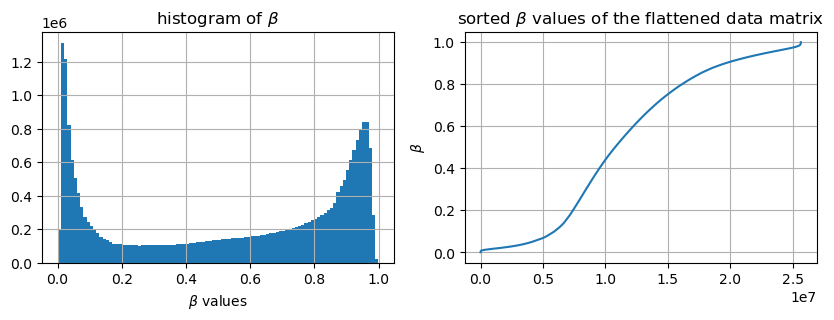

In [5]:
# HISTOGRAM ANALYSIS OF BETA VALUES

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title('histogram of $\\beta$')
plt.hist(X_beta.ravel(),bins=100)
plt.xlabel('$\\beta$ values')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(np.sort(X_beta.ravel()))
plt.title('sorted $\\beta$ values of the flattened data matrix')
plt.ylabel('$\\beta$')
plt.grid(True)
plt.savefig('figures/histogram_betas.pdf')


# Rank normalization
To overcome this, *rank normalization* is proposed. Rank normalization maps each value of $X$ to its *rank* in the flattened matrix(*rank* = position in a sorted list of all $\beta$ values). In our case the rank is scaled to range in the interval $[0,1]$. Rank normalization has some nice properties:
- it is a monothonic transformation
- produces a flat (uniform) histogram, i.e. it equalizes the histogram

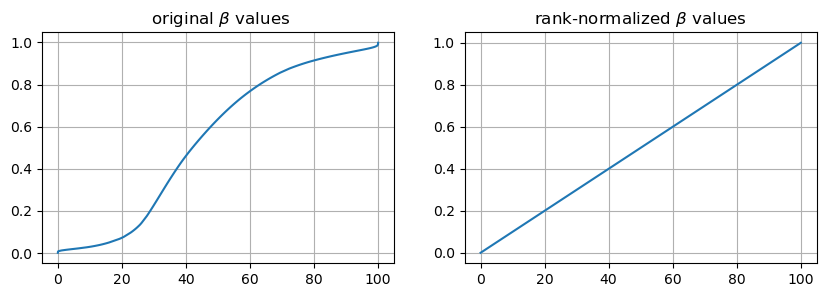

In [6]:
# get the rank for each beta value in X_beta
rank_betas = pd.DataFrame(X_beta.ravel()).rank().values

# reshape back the rank_betas array to the shape of X_beta and scale to [0,1]
X = rank_betas.reshape(X_beta.shape)/rank_betas.max()


plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,100,np.prod(X_beta.shape)),np.sort(X_beta.ravel()))
plt.title(' original $\\beta$ values')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(np.linspace(0,100,np.prod(X.shape)),np.sort(X.ravel()))
plt.title('rank-normalized $\\beta$ values')
plt.grid(True)
plt.savefig('figures/distribution_betas_and_rank_rormalized.pdf')


Now we can plot the histogram of the original $\beta$ values and the histogram of the rank-normalized $\beta$ values

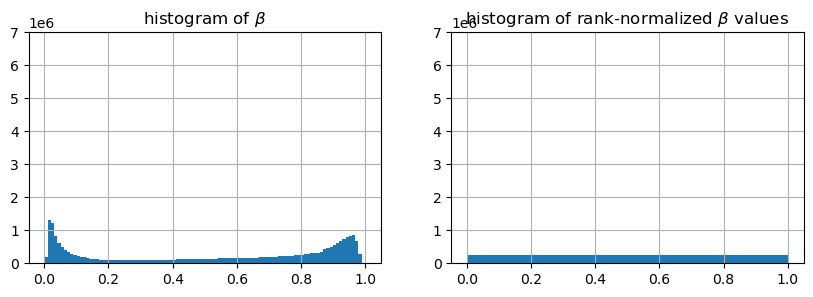

In [7]:
plt.figure(figsize=(10,3))

# original beta values
plt.subplot(1,2,1)
plt.title('histogram of $\\beta$')
plt.hist(X_beta.ravel(),bins=100)
plt.axis(ymax=7e6)
plt.grid(True)

# rank-normalized beta values
plt.subplot(1,2,2)
plt.title('histogram of rank-normalized $\\beta$ values')
plt.hist(X.ravel(),bins=100)
plt.axis(ymax=7e6)
plt.grid(True)
plt.savefig('figures/histogram_betas_and_rank_normalized.pdf')


In [8]:
# EXPERIMENT PARAMETERS

ni,nj = (50,50)					# size of the SOM grid
n_iter = 2000					# number of epochs
batch_size = 300				# size of the minibatches

# neighborhood per epoch
nc = np.logspace(np.log10(20),np.log10(.5), n_iter)

# momentum factor per epoch
t  = np.linspace(0,1,n_iter)
lc = (1 - np.exp(-5*t))


# initialize SOM
gi,mi = inisom(X,[ni,nj])

# random initialization of SOM weights
mi_ = np.random.randn(*mi.shape)

# time statistics
before = time.time()

for i in range(n_iter):
	# minibatch of "batch_size" elements
	idx = np.random.permutation(X.shape[0])[:batch_size]
	xbatch = X[idx,:]

	L = lc[i]
	neigh = nc[i]

	# training step with the minibatch; the current SOM state is updated by the call to bsom()
	mi,mse = bsom(xbatch,gi,mi,neigh)
	# mi,mse = csom(xbatch,gi,mi,neigh)

	# "moment" smooth learning: the weights of the last minibatch are smoothly added to the general weights
	mi_ = L*mi_ + (1-L)*mi
	mi = mi_.copy()

	# show evolution
	if i%50==0:
		print(f'epoch={i}/{n_iter},\t neigh={neigh:.02f},\t momentum={L:.02f},\t mse={mse:.02f},\t dt={time.time()-before:.02f}')
		before = time.time()


epoch=0/2000,	 neigh=20.00,	 momentum=0.00,	 mse=17.51,	 dt=0.02
epoch=50/2000,	 neigh=18.24,	 momentum=0.12,	 mse=0.68,	 dt=1.13
epoch=100/2000,	 neigh=16.63,	 momentum=0.22,	 mse=0.59,	 dt=1.13
epoch=150/2000,	 neigh=15.16,	 momentum=0.31,	 mse=0.60,	 dt=1.13
epoch=200/2000,	 neigh=13.83,	 momentum=0.39,	 mse=0.56,	 dt=1.14
epoch=250/2000,	 neigh=12.61,	 momentum=0.46,	 mse=0.54,	 dt=1.14
epoch=300/2000,	 neigh=11.50,	 momentum=0.53,	 mse=0.54,	 dt=1.14
epoch=350/2000,	 neigh=10.48,	 momentum=0.58,	 mse=0.51,	 dt=1.13
epoch=400/2000,	 neigh=9.56,	 momentum=0.63,	 mse=0.53,	 dt=1.14
epoch=450/2000,	 neigh=8.72,	 momentum=0.68,	 mse=0.47,	 dt=1.15
epoch=500/2000,	 neigh=7.95,	 momentum=0.71,	 mse=0.47,	 dt=1.13
epoch=550/2000,	 neigh=7.25,	 momentum=0.75,	 mse=0.46,	 dt=1.13
epoch=600/2000,	 neigh=6.61,	 momentum=0.78,	 mse=0.45,	 dt=1.13
epoch=650/2000,	 neigh=6.03,	 momentum=0.80,	 mse=0.43,	 dt=1.13
epoch=700/2000,	 neigh=5.50,	 momentum=0.83,	 mse=0.46,	 dt=1.13
epoch=750/2000,	 ne

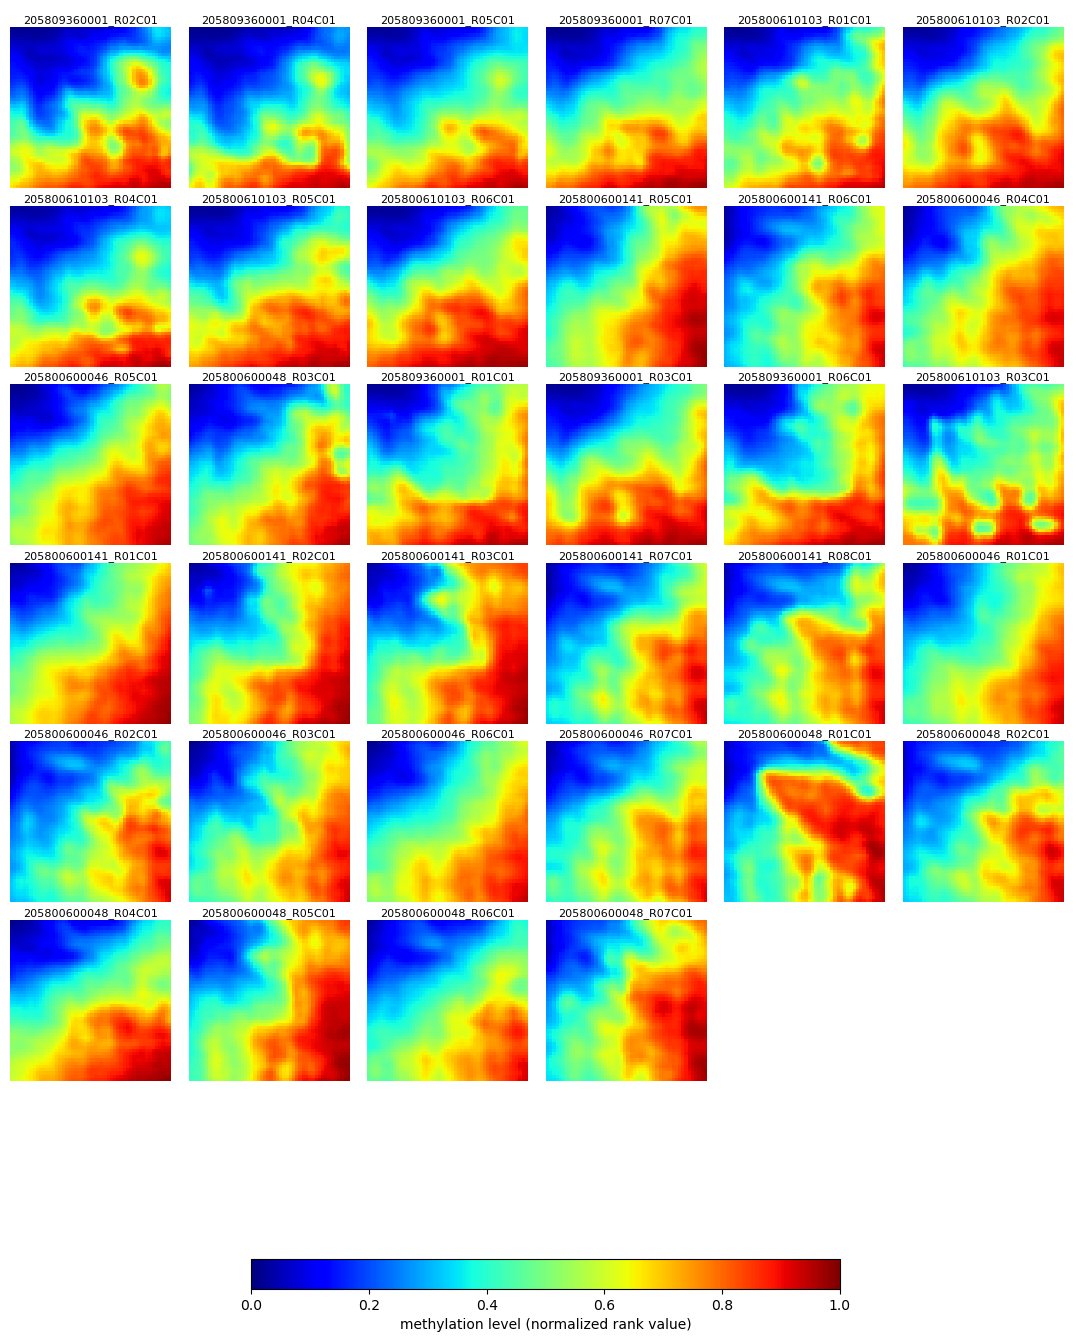

In [9]:
########################
# SOM COMPONENT PLANES
########################
colormap = 'jet'
fig = plt.figure(figsize=(15,15))
ax = fig.subplots()
[ii,jj]=np.meshgrid(np.arange(6),np.arange(6,0,-1))
pos = np.column_stack((ii.reshape(-1,1),jj.reshape(-1,1)))

for i in range(len(obs_labels)):
    img = mi[:,i].reshape(ni,nj)
    ii = pos[i,0]
    jj = pos[i,1]
    ax.imshow(img, extent=np.array([ii, ii+.9, jj, jj+.9]).ravel(), origin='lower', cmap=colormap, vmin=0, vmax=1)
    plt.text(ii+0.45,jj+.925,f'{obs_labels[i]}',fontsize=8,horizontalalignment='center')
ax.set_xlim([0,6])
ax.set_ylim([0,7])


plt.imshow(np.array([[1]]),extent=[0,0,0,0], vmin=0,vmax=1,cmap=colormap)
plt.colorbar(shrink=0.4, location='bottom', pad=0.0, label='methylation level (normalized rank value)')
plt.axis('Off')
plt.tight_layout()

plt.savefig('figures/component_planes.pdf',bbox_inches='tight')



doing t-SNE projection of component planes


/home/idiaz/.conda/envs/mis_cosas/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/idiaz/.conda/envs/mis_cosas/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_2389127/1882957505.py:29: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  plt.imshow(np.array([[1]]),extent=[0,0,0,0], vmin=0,vmax=1,cmap=colormap)
/tmp/ipykernel_2389127/1882957505.py:29: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  plt.imshow(np.array([[1]]),extent=[0,0,0,0], vmin=0,vmax=1,cmap=colormap)


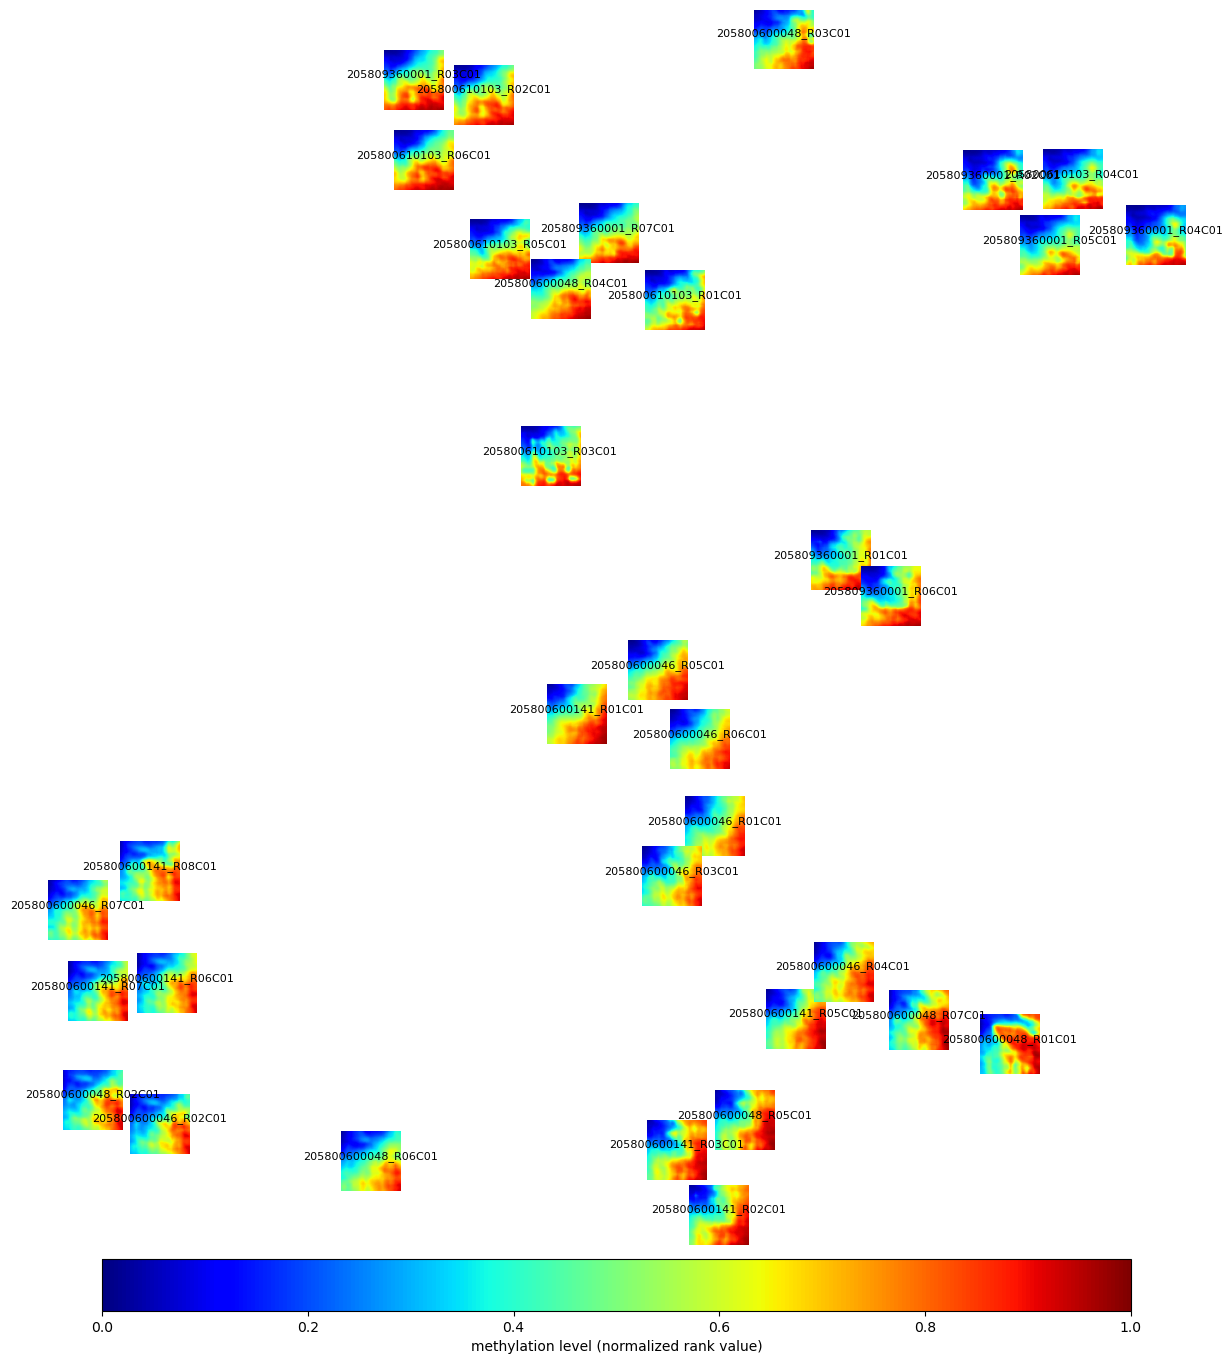

In [10]:
print('doing t-SNE projection of component planes')

dr_method = 'umap'

if dr_method=='tsne':
    dr_map = TSNE(n_components=2,perplexity=5)

elif dr_method=='umap':
    dr_map = TSNE(n_components=2,perplexity=5)

elif dr_method=='pca':
    dr_map = PCA(n_components=2)
    
pr = dr_map.fit_transform(mi.T)

pr = pr/np.abs(np.max(pr))*400

fig = plt.figure(figsize=(15,15))
ax = fig.subplots()
# fig, ax = plt.subplots()
for i in range(pr.shape[0]):
    img = mi[:,i].reshape(ni,nj)
    ax.imshow(img, extent=np.array([pr[i,0]-20,pr[i,0]+20,pr[i,1]-20,pr[i,1]+20]).ravel(), origin='lower', cmap=colormap, vmin=0, vmax=1)
    plt.text(pr[i,0],pr[i,1]+2,obs_labels[i],fontsize=8,horizontalalignment='center')

# plt.imshow(np.array([[1]]), extent=[0,0,0,0], vmin=0,vmax=1,cmap=colormap)
# plt.colorbar(shrink=0.5)
# plt.axis('Off')
plt.imshow(np.array([[1]]),extent=[0,0,0,0], vmin=0,vmax=1,cmap=colormap)
plt.colorbar(shrink=0.7, location='bottom', pad=0.01, label='methylation level (normalized rank value)')
plt.axis('Off')

# a "ghost" scatter forces the image to autoscale
ax.scatter(pr[:,0],pr[:,1],s=0)

plt.tight_layout()
plt.savefig('figures/tsne_projection.pdf',bbox_inches='tight')

pr_tsne = pr.copy()



## Find location of bases from specific genes
We can locate the bases `cgxxxxxxx` that correspond to specific genes of interest, and find their locations in the SOM map. Particularly we are interested in protocadherines, which are known to be related to pheochromocytome cancer processes

In [11]:

####################################################################
# PLOT COMPONENT PLANES WITH CpG SOM LOCATIONS OF ONE OR MORE GENES
####################################################################

# list of genes to which each CpG location belongs
gene_of_each_CpG = df.UCSC_RefGene_Name.tolist()

# list of genes of interest (those whose CpG bases we want to project)
genes_of_interest = ['PCDH']
print(f'plotting activation maps of genes matching {genes_of_interest} ...')




# compute SOM projections of all CpGs included in the list of genes of interest

# initialize the list of indices of CpG bases belonging to any gene of the list
idx = []
for gen in genes_of_interest:
    print(f'processing string "{gen}"')
    idx = idx + np.unique(np.array([gene_of_each_CpG.index(i) for i in gene_of_each_CpG if gen in str(i)])).tolist()
idx = np.array(idx)
gendata = X[idx,:]

# project the CpG bases belonging to the list of genes
pr_som = fproj(gendata,gi,mi,dither=True)[2]




plotting activation maps of genes matching ['PCDH'] ...
processing string "PCDH"


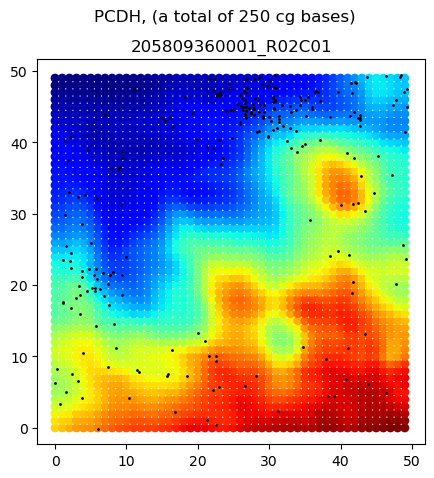

In [12]:

# VISUALIZATION OF A SINGLE COMPONENT PLANE

fig = plt.figure(figsize=(5,5))
fig.suptitle(f"{''.join(genes_of_interest)}, (a total of {len(idx)} cg bases)")
# plt.imshow(mi[:,0].reshape(ni,nj), extent=[0,ni,0,nj], origin='lower', cmap=colormap)

# sample whose SOM componen plane will be visualized
idx_obs = 0
plt.scatter(gi[:,0],gi[:,1],s=30,c=mi[:,idx_obs],cmap=colormap)
plt.scatter(pr_som[:,0],pr_som[:,1],s=1,c='black')
plt.title(obs_labels[idx_obs])
plt.axis('equal')
plt.savefig(f'figures/component_plane_{obs_labels[idx_obs]}.pdf')


PCDH, (a total of 250 CG bases)


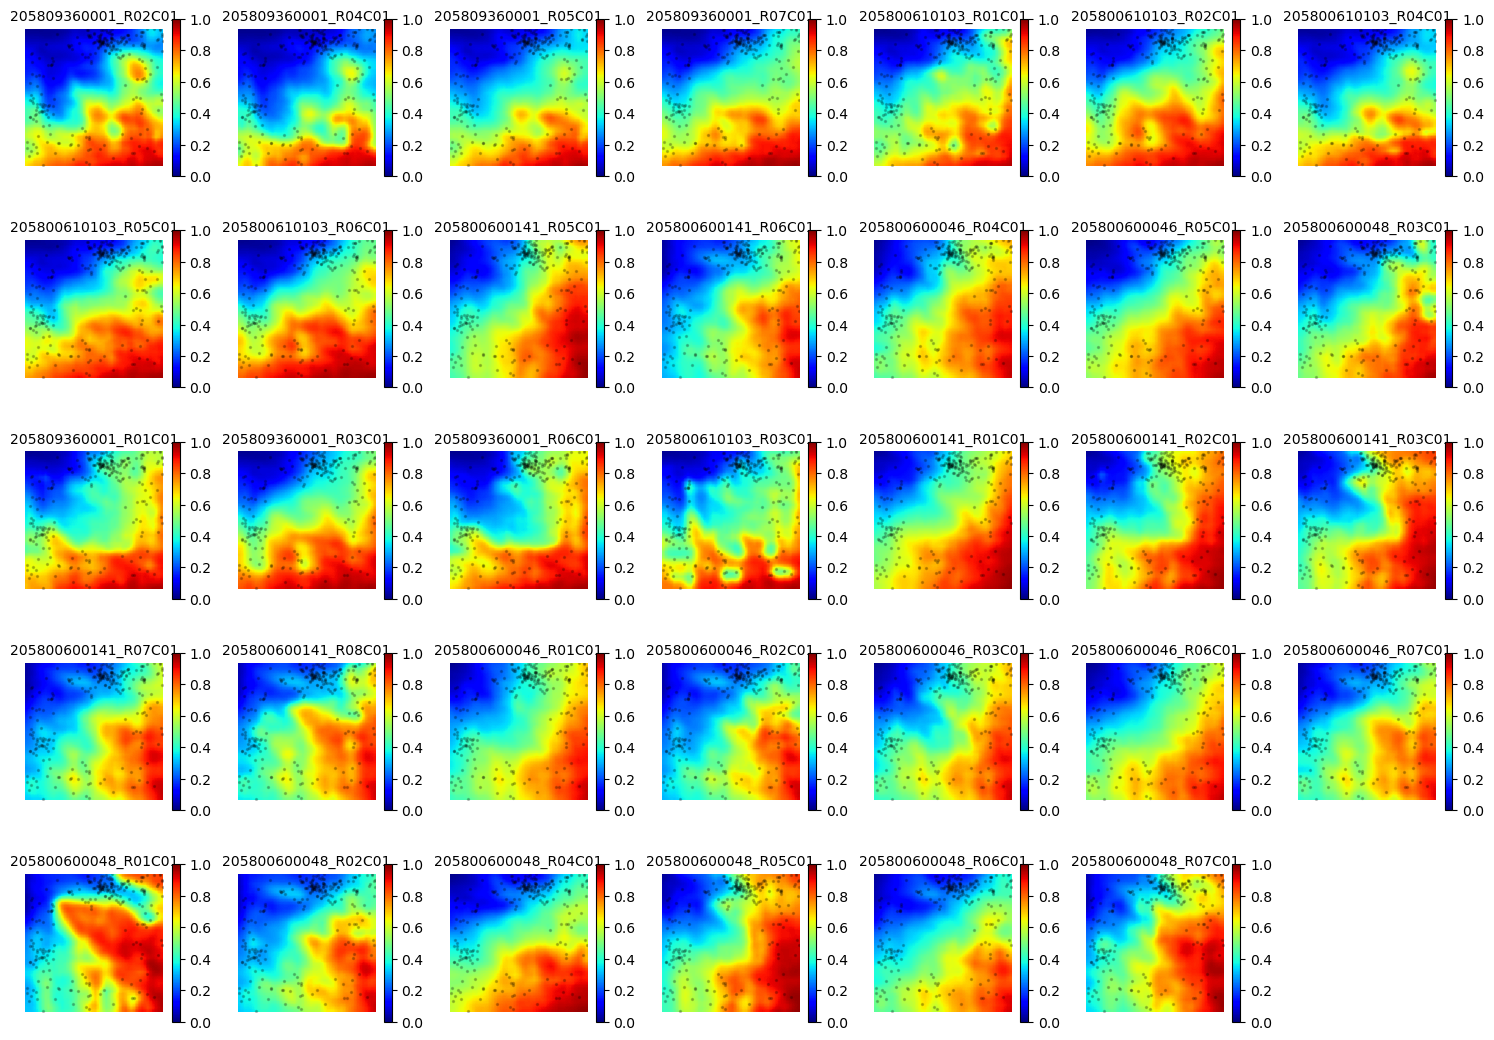

In [13]:
# VISUALIZATION OF ALL COMPONENT PLANES

fig = plt.figure(figsize=(15,15))
print(f"{''.join(genes_of_interest)}, (a total of {len(idx)} CG bases)")

for i in range(34):
    img = mi[:,i].reshape(ni,nj)
    plt.subplot(7,7,i+1)
    plt.imshow(img, origin='lower', cmap=colormap, vmin=0, vmax=1)
    plt.colorbar(shrink=0.8)
    plt.scatter(pr_som[:,0],pr_som[:,1],s=2,color='black',alpha=0.2)
    plt.title(f'{obs_labels[i]}',fontsize=10)
    plt.axis('Off')

plt.tight_layout()
plt.savefig('figures/component_planes_con_genes_proyectados.pdf')


## sort SOM component planes by similarities

A 1-dimensional DR mapping can be used to map the component planes on a 1D latent space. Close projections in the latent space correspond to close samples in the input space, that is "similar" component planes. Rearranging the plotting of the component planes to match their order in the latent space results in a more readable and undestandable view of the planes

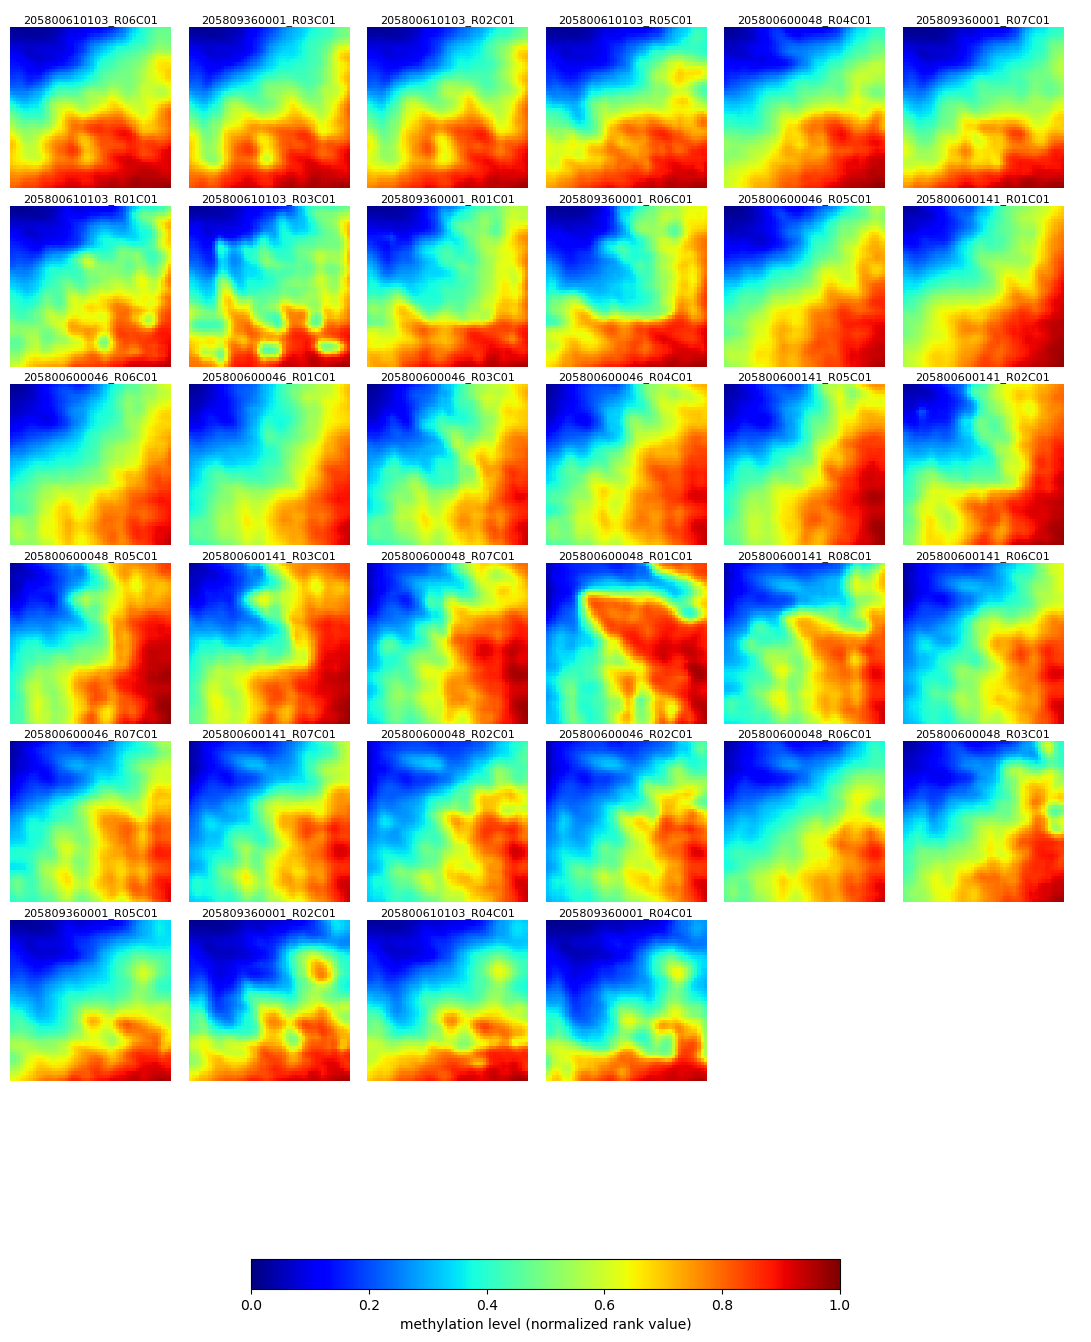

In [14]:
###############################
# SOM COMPONENT PLANES (SORTED)
###############################

# 1d arrange spatially all the samples according their similarities in methylation

dr_method = 'umap'

if dr_method=='umap':
    dr_map = UMAP(n_components=1,min_dist=0.5,n_neighbors=5)
elif dr_method=='tsne':
    dr_map = TSNE(n_components=1,perplexity=5)
elif dr_method=='pca':
    dr_map = PCA(n_components=1)

pr = dr_map.fit_transform(mi.T)
idx_sort_samples = np.argsort(pr.ravel())


colormap = 'jet'
fig = plt.figure(figsize=(15,15))
ax = fig.subplots()
[ii,jj]=np.meshgrid(np.arange(6),np.arange(6,0,-1))
pos = np.column_stack((ii.reshape(-1,1),jj.reshape(-1,1)))

# use the sorted indices instead of original ordering for the samples
for i in range(len(obs_labels)):
    i_sorted = idx_sort_samples[i]
    img = mi[:,i_sorted].reshape(ni,nj)
    ii = pos[i,0]
    jj = pos[i,1]
    ax.imshow(img, extent=np.array([ii, ii+.9, jj, jj+.9]).ravel(), origin='lower', cmap=colormap, vmin=0, vmax=1)
    plt.text(ii+0.45,jj+.925,f'{obs_labels[i_sorted]}',fontsize=8,horizontalalignment='center')
ax.set_xlim([0,6])
ax.set_ylim([0,7])


plt.imshow(np.array([[1]]),extent=[0,0,0,0], vmin=0,vmax=1,cmap=colormap)
plt.colorbar(shrink=0.4, location='bottom', pad=0.0, label='methylation level (normalized rank value)')
plt.axis('Off')
plt.tight_layout()

plt.savefig('figures/component_planes_sorted.pdf',bbox_inches='tight')
